In [ ]:
!git clone https://github.com/col-aatresh/impulse_workshop

Cloning into 'impulse_workshop'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 31 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [ ]:
!pip install numpy
!pip install matplotlib
!pip install opencv-python
!pip install scikit-image
!pip install PyWavelets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
# ssim function is used to calculate the structural similarity index metrix -- used to compare the similarity between images
from skimage.measure import compare_ssim as ssim
# pywt is a popular python library used for conversions between spatial and wavelet domains
import pywt

## Soft Thresholding - A method to enforce sparsity:

soft\_threshold(X) =  \begin{cases} 
      sgn(X)(\vert X \vert - T) & \vert X \vert \geq T \\
      0 & \vert X \vert < T 
        \end{cases}
        

In [ ]:
def soft_threshold(x,t):
    
    """
        Applies the soft thresholding function on x with a threshold t.
        
        Arguments:
            x: vector or matrix to be soft thresholded
            t: threshold
            
        Returns:
            x after the soft threshold operation.
    """
    
    x = np.maximum(np.abs(x) - t,0) * np.sign(x)
    return x

## Denoising using wavelets

![](https://github.com/col-aatresh/impulse_workshop/blob/main/2DDWT.png?raw=1)

The pywavelets library helps us perform quick DWT calculations. [Documentation](https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html)

![](https://github.com/col-aatresh/impulse_workshop/blob/main/pywt_dwt.png?raw=1)

In [ ]:
def dwt_denoise(img,T,lvl):
    
    
    """
        Function to enforce sparsity in the wavelet domain given an image "img" and threshold "T".
        
        Arguments:
            img: intermediate solution
            T: threshold
            lvl: number of levels of dwt
            
        Returns:
            rec: image "img" with sparser wavelet coefficients.
    """
    
    coeff = pywt.wavedec2(img,"haar",level=lvl)
    
    nCA4 = coeff[0]
    l = [nCA4]

    for i in range(1,len(coeff)):
        
        t = coeff[i]

        t0 = soft_threshold(t[0],T)
        t1 = soft_threshold(t[1],T)
        t2 = soft_threshold(t[2],T)

        t = (t0,t1,t2)

        l.append(t)
        
    rec = pywt.waverec2(l,"haar")
    
    return rec

## Cost and gradients:

### Cost:
\begin{gather}
            J(\boldsymbol{x}) = \frac{1}{2}\Vert \boldsymbol{x} - \boldsymbol{y} \Vert ^{2}_{2} + \lambda \Vert \mathbf{W}\boldsymbol{x} \Vert_{1} \\
            \boldsymbol{x}^{*} = \text{argmin}_{\boldsymbol{x}} \{ \frac{1}{2} \Vert \boldsymbol{x} - \boldsymbol{y} \Vert ^{2}_{2} + \lambda \Vert \mathbf{W}\boldsymbol{x} \Vert_{1} \}
        \end{gather}
        
### Gradient:
\begin{equation}
    g = \frac{\partial J(\boldsymbol{x})}{\partial \boldsymbol{x}}
\end{equation}

In [ ]:
def grad(denoised_img,noisy_img):
    
    """
        Calculates the partial gradient
        
        Arguments:
            denoised_img: Intermediate solution or x_k
            noisy_img: the noisy image or y
            
        Returns:
            Returns the partial gradient.
    """
    
    g = denoised_img - noisy_img
    
    return g

# Metrics

## Peak signal-to-noise ratio (PSNR)

PSNR is a commonly used metric to judge the quality of reconstruction, or in this case, denoised solutions. It is a meausre of the ratio between the maximum possible power of the signal and the power of the noise present. 

PSNR = $20 \log_{10} \frac{(MAX\ PIXEL\ VALUE)}{\sqrt{MSE}}$

MSE = mean square error between the reconstructed image and the ground truth image.


## Structural similarity index (SSIM)

SSIM is used to measure the similarity between images similar to the way humans judge their similarity. It takes into account the luminance, contrast and structure of the images.

In [ ]:
def psnr(img1, img2,PIXEL_MAX):
    """
        Calculates the peak signal-to-noise ratio of 2 images
        
        Arguments:
            img1: Image1
            img2: Image2
            PIXEL_MAX: maximum possible pixel intensity in the image
            
        Returns:
            The peak signal-to-noise ratio of the 2 images
    """
    
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100.0
    
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

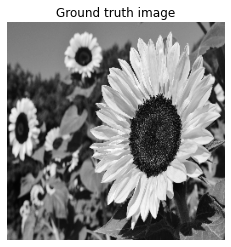

In [ ]:
## Load ground truth image
gt_img = cv2.imread("./impulse_workshop/sunflower.jpg",0)  ## Read an image given the image name
gt_img = cv2.resize(gt_img,(256,256))  ## Resize the image to a more workable size 
gt_img = np.float32(gt_img)  ## type cast the image to a float data type for future calculations

## Displaying the image
plt.axis("off") ## remove x and y axes
plt.title("Ground truth image") ## title of image
plt.imshow(gt_img,cmap = "gray") ## display image using a gray colormap

# Simulating a noisy image

In this experiment, we consider additive white gaussian noise (AWGN) drawn from an independent and identically distributed zero mean distribution with a particular standard of deviation $\sigma$. 

$\mathbf{Y} = \mathbf{X} + \mathbf{E}$, where $\mathbf{E}$ is drawn from $\mathcal{N}(0,\sigma^{2}\mathbf{I})$

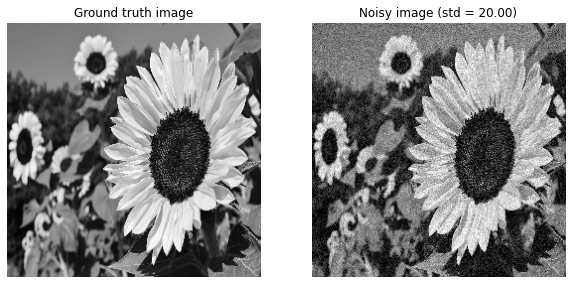

In [ ]:
## Preparing and adding noise
mean = 0.0  ## zero mean
std = 20  ## standard of deviation of noise

noise = np.random.normal(mean,std,size = gt_img.shape)  ## using a numpy function to draw noise samples given mean and std
noisy_img = gt_img + noise  ## simulating a noisy image

noisy_img[noisy_img > 255] = 255  ## cliping noisy above 255 
noisy_img[noisy_img < 0] = 0  ## clipping noise below 0


## visualizing ground truth and noisy images
fig,ax = plt.subplots(1,2,figsize = (10,10))

ax[0].set_title("Ground truth image")
ax[0].axis("off")
ax[0].imshow(gt_img,cmap = "gray")

ax[1].set_title("Noisy image (std = %0.2f)" % (std))
ax[1].axis("off")
ax[1].imshow(noisy_img,cmap = "gray")
plt.show()

## Applying ISTA (iterative shrinkage thresholding algorithm) for image denoising

iteration:  0 PSNR of iteration:  22.91990149285011
iteration:  1 PSNR of iteration:  22.919901492850123
iteration:  2 PSNR of iteration:  22.919901492850116
iteration:  3 PSNR of iteration:  22.91990149285013
iteration:  4 PSNR of iteration:  22.919901492850137
iteration:  5 PSNR of iteration:  22.919901492850137
iteration:  6 PSNR of iteration:  22.91990149285015
iteration:  7 PSNR of iteration:  22.919901492850144
iteration:  8 PSNR of iteration:  22.91990149285013
iteration:  9 PSNR of iteration:  22.91990149285013
iteration:  10 PSNR of iteration:  22.919901492850148
iteration:  11 PSNR of iteration:  22.919901492850148
iteration:  12 PSNR of iteration:  22.919901492850162
iteration:  13 PSNR of iteration:  22.91990149285015
iteration:  14 PSNR of iteration:  22.91990149285013
iteration:  15 PSNR of iteration:  22.919901492850137
iteration:  16 PSNR of iteration:  22.919901492850133
iteration:  17 PSNR of iteration:  22.919901492850137
iteration:  18 PSNR of iteration:  22.9199014

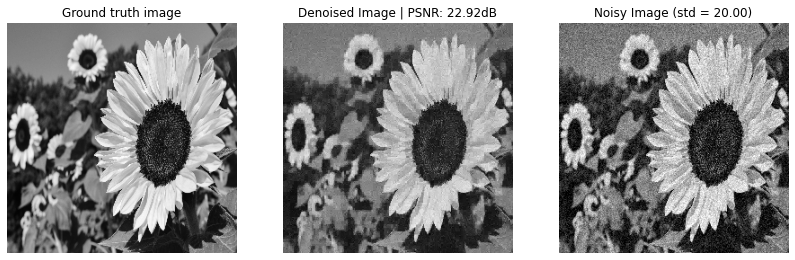

In [ ]:
## initializing the denoised_img variable before starting the iterative process
denoised_img = np.zeros_like(gt_img)

## Number of iterations 
num_iter = 20

## Threshold
T = 2.0

## Number of levels for DWT
lvl = 4

## Learning rate
n=1e-1

## Normalize the ground truth image
gt_img_norm = gt_img / gt_img.max()


## Iterate and find the solution
for i in range(0,num_iter):
    
    ## Calculate partial gradient
    g = grad(denoised_img,noisy_img)
    int_sol = denoised_img - (n * g)
    
    ## Perform soft thresholding in the wavelet domain
    denoised_img = dwt_denoise(int_sol,T,lvl)

    ## Normalize the intermediate denoised image
    denoised_img_norm = denoised_img / denoised_img.max()

    print("iteration: ",i,"PSNR of iteration: ",psnr(gt_img_norm,denoised_img_norm,1.0))
    
    
## Displaying images
fig,ax = plt.subplots(1,3,figsize = (14,14))

plt.axis("off")
ax[0].set_title("Ground truth image")
ax[0].axis("off")
ax[0].imshow(gt_img,cmap = "gray")

ax[1].set_title("Denoised Image | PSNR: %0.2fdB" % (psnr(gt_img_norm,denoised_img_norm,1.0)))
ax[1].axis("off")
ax[1].imshow(denoised_img,cmap = "gray")

ax[2].set_title("Noisy Image (std = %0.2f)" % (std))
ax[2].axis("off")
ax[2].imshow(noisy_img,cmap = "gray")

plt.show()

In [ ]:
## Normalize the noisy image
noisy_img_norm = noisy_img / noisy_img.max()

print("PSNR before denoising: ",psnr(gt_img_norm,noisy_img_norm,1.0))
print("PSNR after denoising: ",psnr(gt_img_norm,denoised_img_norm,1.0))

print("SSIM before denoising: ",ssim(noisy_img_norm,gt_img_norm,data_range = noisy_img_norm.max() - noisy_img_norm.min()))
print("SSIM after denoising: ",ssim(denoised_img_norm,gt_img_norm,data_range = denoised_img_norm.max() - denoised_img_norm.min()))

PSNR before denoising:  21.592284152123852
PSNR after denoising:  22.919901492850148
SSIM before denoising:  0.6483109626205202
SSIM after denoising:  0.7450303269862254


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
